# Backend Location

In [1]:
import os
import numpy as np
import pandas as pd
import datetime

#implemented
from src.backend.api_wrapper import getData

In [2]:
#helper
def dist2DDeg_KM(x,y):
    """
        Approx distance
    """
    dLon =x["lon"]-y["latitude"]
    dLat =x["lat"]-y["longitude"]
    return dLat*111.32+(40075*np.cos(dLat)/360) *dLon


# Ranking functionality

## input

In [3]:
#Input:
startLocation = "Zürich HB"
starting_time = datetime.datetime.fromisoformat('2021-10-30T12:02:00.036331')

destination = "Ilanz" #None
destination = "Zug"
destination_radius = 50000

suprise:bool = False
    
experience = None
redoAll=False

In [4]:
#Meta Statistics
loss_data = {}

## retrieve Data

In [5]:
oa = getData.outdoor_active()
js = getData.journey_service()
timetable = getData.timetable_info()
weather = getData.weather_forcast()


In [6]:
#Get starting Info
startLocation_OBJ = timetable.get_locationRequest(location=startLocation)[0]
startLocation_ID = startLocation_OBJ["id"]

destination_OBJ = timetable.get_locationRequest(location=destination)[0]
destination_ID = destination_OBJ["id"]
destination_OBJ


https://b2p-int.api.sbb.ch/api/locations?name=Z%C3%BCrich+HB
200
[{"id":8503000,"name":"Zürich HB","coordinates":{"latitude":47.378177,"longitude":8.540193},"type":"STATION","tariffBorder":false,"weight":32173,"vehicleTypes":["TRAIN"],"links":[]},{"id":8503088,"name":"Zürich HB SZU","coordinates":{"latitude":47.377431,"longitude":8.539168},"type":"STATION","tariffBorder":false,"weight":2805,"vehicleTypes":["TRAIN"],"links":[]},{"id":8587348,"name":"Zürich, Bahnhofplatz/HB","coordinates":{"latitude":47.377242,"longitude":8.539339},"type":"STATION","tariffBorder":false,"weight":3090,"vehicleTypes":["BUS","TRAMWAY"],"links":[]},{"id":8587349,"name":"Zürich, Bahnhofquai/HB","coordinates":{"latitude":47.377557,"longitude":8.541739},"type":"STATION","tariffBorder":false,"weight":3090,"vehicleTypes":["BUS","TRAMWAY"],"links":[]},{"id":8591367,"name":"Zürich, Sihlpost/HB","coordinates":{"latitude":47.376092,"longitude":8.534206},"type":"STATION","tariffBorder":false,"weight":3090,"vehicleTypes

{'id': 8502204,
 'name': 'Zug',
 'coordinates': {'latitude': 47.173628, 'longitude': 8.515293},
 'type': 'STATION',
 'tariffBorder': False,
 'weight': 24047,
 'vehicleTypes': ['TRAIN'],
 'links': []}

In [7]:
oa_df = oa.get_dataframe_of_ch(getData.get_coords_request(lat=destination_OBJ["coordinates"]['latitude'], 
                                                          lon=destination_OBJ["coordinates"]['longitude']),
                                                          radius=destination_radius)

In [8]:
oa_df.columns

Index(['lineOptions', 'time', 'length', 'elevation', 'rating', 'labels',
       'startingPoint', 'season', 'startingPointDescr', 'directions',
       'equipment', 'tip', 'destination', 'properties', 'pois',
       'elevationProfile', 'wayType', 'currentConditions', 'difficulties',
       'category', 'title', 'localizedTitle', 'shortText', 'longText',
       'primaryImage', 'geometry', 'images', 'regions', 'winterActivity',
       'meta', 'id', 'type', 'frontendtype', 'ranking', 'publicTransit',
       'gettingThere', 'parking', 'safetyGuidelines', 'additionalInformation',
       'groundDescription', 'crestDescription', 'opened', 'riskPotential',
       'exposition', 'bookWorks', 'avalancheRegions', 'isStageTour',
       'stageTour', 'stageTours', 'isStagesTour', 'joinPointMeter',
       'wallHeight', 'climbingLengthMeter', 'descentMeter',
       'joinPointDuration', 'climbingLengthDuration', 'descentDuration',
       'mapWorks'],
      dtype='object')

In [9]:
oa_df["startingPoint"]

0               {'lon': 8.595566, 'lat': 46.919714}
1               {'lon': 8.571873, 'lat': 47.381701}
2               {'lon': 9.070858, 'lat': 47.040117}
3               {'lon': 8.573265, 'lat': 47.358164}
4               {'lon': 8.816476, 'lat': 47.225099}
                           ...                     
659    {'lon': 8.958437, 'lat': 46.908973999999986}
660    {'lon': 8.900458, 'lat': 46.889777999999986}
661              {'lon': 8.525863, 'lat': 46.99237}
662             {'lon': 8.203416, 'lat': 47.484261}
663     {'lon': 8.645602, 'lat': 46.83650799999999}
Name: startingPoint, Length: 664, dtype: object

In [10]:
oa_df.rating[0]

{'condition': 4,
 'difficulty': 2,
 'technique': 2,
 'qualityOfExperience': 3,
 'landscape': 5}

In [11]:
oa_df.shape

(664, 58)

### Outdoor Activity convenvience Metric

#### Get all close stations to the hikes

In [12]:
oa_df_path = "oa_df_withStations.obj"
if(not os.path.exists(oa_df_path) or redoAll):
    oa_df['closeStations'] = oa_df.apply(lambda x: js.get_locationRequestByCoords(getData.get_coords_request(**x['startingPoint'])), axis=1)
    oa_df.to_pickle(oa_df_path)
else:
    oa_df = pd.read_pickle("oa_df_withStations.obj")    
oa_df.shape

(664, 59)

In [13]:
oa_df['closeStations']

0      [{'type': 'STATION', 'uicOrId': '8573095', 'na...
1      [{'type': 'STATION', 'uicOrId': '8591442', 'na...
2      [{'type': 'STATION', 'uicOrId': '8503230', 'na...
3      [{'type': 'STATION', 'uicOrId': '8591104', 'na...
4      [{'type': 'STATION', 'uicOrId': '8503110', 'na...
                             ...                        
659    [{'type': 'STATION', 'uicOrId': '8505740', 'na...
660    [{'type': 'STATION', 'uicOrId': '8505776', 'na...
661    [{'type': 'STATION', 'uicOrId': '8509538', 'na...
662    [{'type': 'STATION', 'uicOrId': '8580324', 'na...
663    [{'type': 'STATION', 'uicOrId': '8577384', 'na...
Name: closeStations, Length: 664, dtype: object

#### Get closest station to the hikes

In [14]:
#clean empty stations:
f_oa_df = oa_df
drop_empty_stations = [i for i, row in oa_df.iterrows() if(len(row['closeStations'])==0)]

loss_noStation = f_oa_df.iloc[drop_empty_stations]
f_oa_df=f_oa_df.drop(index=drop_empty_stations)
loss_data.update({"noStation":loss_noStation})

f_oa_df.shape

(603, 59)

In [15]:
next_station = []
next_station_d = []
closeStations = []
for i, row in f_oa_df.iterrows():
        if(isinstance(row['closeStations'],list)):
            stations = row['closeStations'] 
            print(type(stations), stations)
            close_stations_distances = [dist2DDeg_KM(row['startingPoint'],station['coordinatesWGS84'])/1000 for station in stations]
            closest_station_i = np.argmin(close_stations_distances)
            closest_station_dmin = np.min(close_stations_distances)
            closest_station = row['closeStations'][closest_station_i]

            #Add info to closeStations
            print(row['closeStations'],)
            [station.update({"distanceToOA": dist}) for station, dist in zip(stations, close_stations_distances)]
            closeStations.append(stations)
            next_station.append(closest_station)
            next_station_d.append(closest_station_dmin)
        else:
            closeStations.append(np.nan)
            next_station.append(np.nan)
            next_station_d.append(np.nan)
        #print("closest_station: ",closest_station_i, closest_station_dmin)
#print(len(close_stations))
f_oa_df["nextStation"] = pd.Series(next_station) 
f_oa_df["closeStations"] = pd.Series(closeStations) 

f_oa_df.dropna(how='all', inplace=True)
f_oa_df.dropna(subset=["closeStations"], inplace=True)

f_oa_df.shape

<class 'list'> [{'type': 'STATION', 'uicOrId': '8573095', 'name': 'Isleten-Isenthal,Schiffstation', 'coordinatesWGS84': {'longitude': 8.59562, 'latitude': 46.919835, 'latitudeDecimalDegrees': 46.919835, 'longitudeDecimalDegrees': 8.59562}, 'cantonCH': 'UR', 'distance': 13, 'categories': [], 'vehicleTypes': ['BUS'], 'weight': 3, 'destinationTrends': None, 'tariffBorderPoint': False}, {'type': 'STATION', 'uicOrId': '8508475', 'name': 'Isleten-Isenthal', 'coordinatesWGS84': {'longitude': 8.595755, 'latitude': 46.919925, 'latitudeDecimalDegrees': 46.919925, 'longitudeDecimalDegrees': 8.595755}, 'cantonCH': 'UR', 'distance': 27, 'categories': [], 'vehicleTypes': ['BOAT'], 'weight': 110, 'destinationTrends': None, 'tariffBorderPoint': False}, {'type': 'STATION', 'uicOrId': '8505918', 'name': 'Isleten, Seegarten', 'coordinatesWGS84': {'longitude': 8.595351, 'latitude': 46.917516, 'latitudeDecimalDegrees': 46.917516, 'longitudeDecimalDegrees': 8.595351}, 'cantonCH': 'UR', 'distance': 245, 'cat

(547, 60)

In [16]:
closest_station

{'type': 'STATION',
 'uicOrId': '8587505',
 'name': 'Erstfeld, Birtschen',
 'coordinatesWGS84': {'longitude': 8.647326,
  'latitude': 46.828208,
  'latitudeDecimalDegrees': 46.828208,
  'longitudeDecimalDegrees': 8.647326},
 'cantonCH': 'UR',
 'distance': 932,
 'categories': [],
 'vehicleTypes': ['BUS'],
 'weight': 471,
 'destinationTrends': None,
 'tariffBorderPoint': False,
 'distanceToOA': 0.5010338437236788}

In [17]:
f_oa_df

,lineOptions,time,length,elevation,rating,labels,startingPoint,season,startingPointDescr,directions,...,joinPointMeter,wallHeight,climbingLengthMeter,descentMeter,joinPointDuration,climbingLengthDuration,descentDuration,mapWorks,closeStations,nextStation
0,{'strokeColor': '#8b5831'},{'min': 210},28499.000000,"{'ascent': 1284, 'descent': 1284, 'minAltitude...","{'condition': 4, 'difficulty': 2, 'technique':...",{'top': True},"{'lon': 8.595566, 'lat': 46.919714}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Isleten, Schiffshafen",Isleten - Isenthal - Biwaldalp - Isenthal - Sc...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8573095', 'na...","{'type': 'STATION', 'uicOrId': '8508475', 'nam..."
1,{'strokeColor': '#8b5831'},{'min': 150},21122.000000,"{'ascent': 444, 'descent': 444, 'minAltitude':...","{'condition': 4, 'difficulty': 2, 'technique':...","{'top': True, 'publicTransportFriendly': True}","{'lon': 8.571873, 'lat': 47.381701}","{'jan': False, 'feb': False, 'mar': True, 'apr...",Zoo Zürich,Zoo Zürich - Lorenchopf - Forch - Zollikerberg...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8591442', 'na...","{'type': 'STATION', 'uicOrId': '8591443', 'nam..."
2,{'strokeColor': '#8b5831'},{'min': 150},15252.596960,"{'ascent': 628, 'descent': 628, 'minAltitude':...","{'condition': 4, 'difficulty': 2, 'qualityOfEx...","{'top': True, 'publicTransportFriendly': True}","{'lon': 9.070858, 'lat': 47.040117}","{'jan': False, 'feb': False, 'mar': True, 'apr...","Glarus, Bahnhof",Glarus-Schwammhöhe-Glarus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8503230', 'na...","{'type': 'STATION', 'uicOrId': '8580486', 'nam..."
3,{'strokeColor': '#8b5831'},{'min': 138},19130.579100,"{'ascent': 482, 'descent': 518, 'minAltitude':...","{'condition': 3, 'difficulty': 2, 'technique':...","{'top': True, 'publicTransportFriendly': True}","{'lon': 8.573265, 'lat': 47.358164}","{'jan': False, 'feb': False, 'mar': True, 'apr...","Zürich Burgwies, Tram Station","<p>Zürich Burgwies, Tram Station - Trichtenhau...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8591104', 'na...","{'type': 'STATION', 'uicOrId': '8591424', 'nam..."
4,{'strokeColor': '#db38c9'},{'min': 559},147652.975712,"{'ascent': 2489, 'descent': 2517, 'minAltitude...","{'condition': 6, 'difficulty': 3, 'technique':...","{'top': True, 'publicTransportFriendly': True}","{'lon': 8.816476, 'lat': 47.225099}","{'jan': False, 'feb': False, 'mar': False, 'ap...",Bahnhof Rapperswil,Von Rapperswil geht es über den Seedamm und da...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8503110', 'na...","{'type': 'STATION', 'uicOrId': '8591754', 'nam..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,{'strokeColor': '#326f9e'},{'min': 330},13436.134897,"{'ascent': 770, 'descent': 770, 'minAltitude':...","{'condition': 5, 'difficulty': 3, 'technique':...",NaN,"{'lon': 8.468315, 'lat': 46.80115999999999}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Bergstation Fürenalp, Hundschuft",Fürenalp - Surenenpass - Brüsti,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8508692', 'na...","{'type': 'STATION', 'uicOrId': '8508692', 'nam..."
598,{'strokeColor': '#326f9e'},{'min': 120},3738.828847,"{'ascent': 385, 'descent': 385, 'minAltitude':...","{'condition': 2, 'difficulty': 2, 'technique':...",NaN,"{'lon': 7.941934000000001, 'lat': 46.994313999...","{'jan': False, 'feb': False, 'mar': False, 'ap...",Mettlenalp BE,Mettlenalp - Fritzefllue - Ahorn - Luthern,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8505740', 'na...","{'type': 'STATION', 'uicOrId': '8505740', 'nam..."
600,{'strokeColor': '#8b5831'},{'min': 150},25150.378018,"{'ascent': 512, 'descent': 512, 'minAltitude':...","{'condition': 4, 'difficulty': 2, 'technique':...",NaN,"{'lon': 8.275, 'lat': 46.940659999999994}","{'jan': False, 'feb': Fa

#### get travel route

In [18]:
#Travel Time and changes
def get_nextStation_trip(destinationStation_ID, startLocation_ID, starting_time):
    trip_request = getData.generate_trip_dict(originId=startLocation_ID,
                                              destinationId=destinationStation_ID,
                                              date=starting_time.date(),
                                              time=starting_time.time())
    print(trip_request)
    trips = timetable.get_tripRequest(trip_request)
    if(len(trips) == 0):
        return np.nan
    else:
        t_deltas = []
        segments = []
        for trip in trips:
            start_time = datetime.datetime.fromisoformat(trip['segments'][0]['stops'][0]['departureDateTime'])
            end_time = datetime.datetime.fromisoformat(trip['segments'][-1]['stops'][-1]["arrivalDateTime"])
            deltaT = end_time-start_time
            trip.update({"t": deltaT, "nSegments":len(trip['segments'])})
            segments.append(len(trip['segments']))
            t_deltas.append(deltaT.seconds)

        return trips
    
def get_fastest_trip(trips):
    if(isinstance(trips, float)  or (isinstance(trips, list) and len(trips)==0)):
        return np.nan
    else:
        t_deltas = []
        segments = []
        for trip in trips:
            print(trip)
            segments.append(trip['nSegments'])
            t_deltas.append(trip['t'])
            
        fastest_trip_i = np.argmin(t_deltas)
        fastest_trip = trips[np.argmin(t_deltas)]
        return fastest_trip
    
    
trip_oa_df_path = "oa_df_withStations_withTrips.obj"
if(not os.path.exists(trip_oa_df_path) or redoAll):
    trip_oa_df = f_oa_df
    
    all_trips = []
    for i, row in trip_oa_df.iterrows():
        print(row["nextStation"]['uicOrId'])
        ts = get_nextStation_trip(row["nextStation"]['uicOrId'], startLocation_ID=startLocation_ID, starting_time=starting_time)
        all_trips.append(ts)
    
    
    trip_oa_df["tripsToDestination"] = pd.Series(all_trips)
    #trip_oa_df["tripsToDestination"] = trip_oa_df.apply(lambda x: get_nextStation_trip(x["nextStation"]['uicOrId'], startLocation_ID=startLocation_ID, starting_time=starting_time), axis=1)
    trip_oa_df["fastestTripToDestination"] = trip_oa_df.apply(lambda x: get_fastest_trip(x["tripsToDestination"]), axis=1)
    
    trip_oa_df["tripsToHome"] = trip_oa_df.apply(lambda x: get_nextStation_trip(startLocation_ID=startLocation_ID, destinationStation_ID=x["nextStation"]['uicOrId'], starting_time=starting_time+datetime.timedelta(minutes=x["time"]["min"])), axis=1)
    trip_oa_df["fastestTripHome"] = trip_oa_df.apply(lambda x: get_fastest_trip(x["tripsToHome"]), axis=1)

    loss_noTrip = [i for i, row in oa_df.iterrows() if(row['fastestTripToDestination'] == np.nan or row['fastestTripHome'] == np.nan )]
    loss_data.update({"noTrip":loss_noTrip})

    trip_oa_df.to_pickle(trip_oa_df_path)
else:
    trip_oa_df = pd.read_pickle(trip_oa_df_path)

trip_oa_df.dropna(subset=["fastestTripToDestination", "fastestTripHome"], inplace=True)

trip_oa_df.shape

(443, 64)

In [19]:
trip_oa_df["tripsToDestination"]

0      [{'tripId': 'xBLwSQoCVjESugfCtkhLScK2VCRBPTFAT...
1      [{'tripId': '3AjwSQoCVjEShwXCtkhLScK2VyRBPTFAT...
2      [{'tripId': 'jQvwSQoCVjES-wTCtkhLScK2VCRBPTFAT...
3      [{'tripId': 'oQjwSQoCVjES6APCtkhLScK2VyRBPTFAT...
4      [{'tripId': '4wvwSQoCVjES7gTCtkhLScK2VCRBPTFAT...
                             ...                        
541    [{'tripId': '5QzwSQoCVjES7QTCtkhLScK2VCRBPTFAT...
542    [{'tripId': '5A_wSQoCVjESiAbCtkhLScK2VCRBPTFAT...
544    [{'tripId': '9x3wSQoCVjESuQrCtkhLScK2VCRBPTFAT...
545    [{'tripId': 'iAnwSQoCVjESggXCtkhLScK2VCRBPTFAT...
546    [{'tripId': '7w7wSQoCVjES-wTCtkhLScK2VCRBPTFAT...
Name: tripsToDestination, Length: 443, dtype: object

In [20]:
trip_oa_df['tripsToHome']

0      [{'tripId': 'xhLwSQoCVjESvAfCtkhLScK2VCRBPTFAT...
1      [{'tripId': '3QjwSQoCVjEShwXCtkhLScK2VyRBPTFAT...
2      [{'tripId': 'jwvwSQoCVjES_QTCtkhLScK2VCRBPTFAT...
3      [{'tripId': 'zw3wSQoCVjES1wbCtkhLScK2VCRBPTFAT...
4      [{'tripId': '4wvwSQoCVjES7gTCtkhLScK2VCRBPTFAT...
                             ...                        
541    [{'tripId': 'wBvwSQoCVjESvgfCtkhLScK2VCRBPTFAT...
542    [{'tripId': 'lh3wSQoCVjESkw3CtkhLScK2VCRBPTFAT...
544    [{'tripId': '8BDwSQoCVjESngfCtkhLScK2VCRBPTFAT...
545    [{'tripId': '0-BLwSQoCVjES5AjCtkhLScK2VCRBPTFA...
546    [{'tripId': '5xbwSQoCVjESmArCtkhLScK2VCRBPTFAT...
Name: tripsToHome, Length: 443, dtype: object

### Extract Features

In [21]:
fastest_trip_time = pd.Series([float(x['t'].seconds)/60 for x in trip_oa_df["fastestTripToDestination"]])
nsegments_trip = pd.Series([float(x['nSegments']) for x in trip_oa_df["fastestTripToDestination"]])
last_mileDist = pd.Series([float(x['distanceToOA']) for x in trip_oa_df["nextStation"]])
oaUserRating = pd.Series([int(x['qualityOfExperience'])+int(x['landscape']) for x in trip_oa_df['rating']])

trip_oa_df["feat_tripTime"] = fastest_trip_time
trip_oa_df["feat_nsegments_trip"] = nsegments_trip
trip_oa_df["feat_lastMile"] = last_mileDist.round(2)
trip_oa_df["feat_oaUserRating"] = -oaUserRating

#### judge travel convenience

In [22]:
sortedtrip_oa_df = trip_oa_df.sort_values(by=['feat_tripTime',"feat_oaUserRating", "feat_lastMile", "feat_nsegments_trip"])
sortedtrip_oa_df

,lineOptions,time,length,elevation,rating,labels,startingPoint,season,startingPointDescr,directions,...,closeStations,nextStation,tripsToDestination,fastestTripToDestination,tripsToHome,fastestTripHome,feat_tripTime,feat_nsegments_trip,feat_lastMile,feat_oaUserRating
255,{'strokeColor': '#326f9e'},{'min': 480},17203.724652,"{'ascent': 656, 'descent': 656, 'minAltitude':...","{'condition': 6, 'difficulty': 3, 'technique':...",NaN,"{'lon': 8.12577, 'lat': 46.89294}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Glaubenbergpassstrasse, Langis",Langis - Glaubenberg - Alp Rick - Rickhubel - ...,...,"[{'type': 'STATION', 'uicOrId': '8508467', 'na...","{'type': 'STATION', 'uicOrId': '8572948', 'nam...",[{'tripId': 'iAjwSQoCVjESrQLCtkhLScK2VCRBPTFAT...,{'tripId': 'sAnwSQoCVjES2APCtkhLScK2VCRBPTFATz...,[{'tripId': 'zSHwSQoCVjES2QzCtkhLScK2VCRBPTFAT...,{'tripId': 'yxrwSQoCVjESwAvCtkhLScK2VCRBPTFATz...,6.0,2.0,1.69,-4.0
111,{'strokeColor': '#2e5676'},{'min': 120},8206.000000,"{'ascent': 535, 'descent': 535, 'minAltitude':...","{'condition': 1, 'difficulty': 2, 'technique':...",{'top': True},"{'lon': 9.174132, 'lat': 47.14726499999998}","{'jan': True, 'feb': True, 'mar': True, 'apr':...","Amden, Arvenbüel","Amden, Arvenbüel - Gulmen (Amden - SG)",...,"[{'type': 'STATION', 'uicOrId': '8530682', 'na...","{'type': 'STATION', 'uicOrId': '8508735', 'nam...",[{'tripId': 'pw_wSQoCVjESyQfCtkhLScK2VCRBPTFAT...,{'tripId': 'sxPwSQoCVjES2wjCtkhLScK2VCRBPTFATz...,[{'tripId': 'vx7wSQoCVjES_QzCtkhLScK2VCRBPTFAT...,{'tripId': 'hhrwSQoCVjESkQrCtkhLScK2VCRBPTFATz...,7.0,3.0,1.67,-4.0
117,{'strokeColor': '#9e324a'},{'min': 120},7762.098700,"{'ascent': 79, 'descent': 101, 'minAltitude': ...","{'condition': 2, 'difficulty': 1, 'technique':...","{'top': True, 'publicTransportFriendly': True}","{'lon': 8.245702, 'lat': 47.461042}","{'jan': True, 'feb': True, 'mar': True, 'apr':...","Birmenstorf, Bushaltestelle",Birmenstorf - Lindmühle - Mellingen,...,"[{'type': 'STATION', 'uicOrId': '8595455', 'na...","{'type': 'STATION', 'uicOrId': '8595208', 'nam...",[{'tripId': 'tg3wSQoCVjESpwbCtkhLScK2VCRBPTFAT...,{'tripId': 'tg3wSQoCVjESpwbCtkhLScK2VCRBPTFATz...,[{'tripId': 'nCLwSQoCVjES6w_CtkhLScK2VCRBPTFAT...,{'tripId': 'nCLwSQoCVjES6w_CtkhLScK2VCRBPTFATz...,14.0,2.0,3.45,-4.0
166,{'strokeColor': '#8b5831'},{'min': 90},8499.000000,"{'ascent': 396, 'descent': 396, 'minAltitude':...","{'condition': 2, 'difficulty': 2, 'technique':...",{'top': True},"{'lon': 8.514268, 'lat': 46.956607}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Emmetten, Bike Arena",Emmetten - Brennwald - Oberwald - Emmetten,...,"[{'type': 'STATION', 'uicOrId': '8508215', 'na...","{'type': 'STATION', 'uicOrId': '8577337', 'nam...",[{'tripId': '4wvwSQoCVjES7gTCtkhLScK2VCRBPTFAT...,{'tripId': '4wvwSQoCVjES7gTCtkhLScK2VCRBPTFATz...,[{'tripId': 'gw3wSQoCVjESnQbCtkhLScK2VCRBPTFAT...,{'tripId': 'nAzwSQoCVjESmQbCtkhLScK2VCRBPTFATz...,15.0,3.0,1.44,-4.0
216,{'strokeColor': '#9e324a'},{'min': 150},8912.999373,"{'ascent': 358, 'descent': 358, 'minAltitude':...","{'condition': 2, 'difficulty': 1, 'technique':...",NaN,"{'lon': 8.507344999999999, 'lat': 47.310199999...","{'jan': False, 'feb': False, 'mar': False, 'ap...","Felsenegg, Bergstation Seilbahn",Felsenegg - Balderen - Mädikon - Folenweid - U...,...,"[{'type': 'STATION', 'uicOrId': '8530682', 'na...","{'type': 'STATION', 'uicOrId': '8508735', 'nam...",[{'tripId': '4Q_wSQoCVjES8AjCtkhLScK2VCRBPTFAT...,{'tripId': '4Q_wSQoCVjES8AjCtkhLScK2VCRBPTFATz...,[{'tripId': 'wyLwSQoCVjESqgvCtkhLScK2VCRBPTFAT...,{'tripId': 'hhrwSQoCVjESkQrCtkhLScK2VCRBPTFATz...,17.0,4.0,1.83,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,{'strokeColor': '#8b5831'},{'min': 300},48802.542630,"{'ascent': 1539, 'descent': 1539, 'minAltitude...","{'condition': 6, 'difficulty': 3, 'technique':...",NaN,"{'lon': 8.74507, 'lat': 47.12846999999999}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Einsiedeln, Bahnhof",Einsiedeln - 

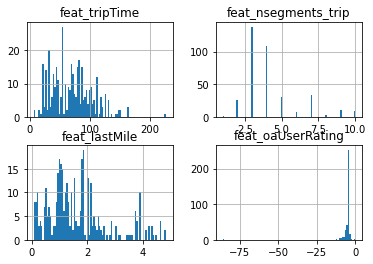

In [23]:
data = trip_oa_df.hist(column=[x for x in trip_oa_df.columns if("feat" in x)], bins=int(np.ceil(trip_oa_df.shape[0]*0.2)))

In [24]:
vars(data[0][0])

{'_stale': True,
 'stale_callback': <function matplotlib.figure._stale_figure_callback(self, val)>,
 '_axes': <AxesSubplot:title={'center':'feat_tripTime'}>,
 'figure': <Figure size 432x288 with 4 Axes>,
 '_transform': None,
 '_transformSet': False,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': None,
 '_clippath': None,
 '_clipon': True,
 '_label': '',
 '_picker': None,
 '_contains': None,
 '_rasterized': False,
 '_agg_filter': None,
 '_mouseover': False,
 '_callbacks': <matplotlib.cbook.CallbackRegistry at 0x1811c2310a0>,
 '_remove_method': <bound method FigureBase.delaxes of <Figure size 432x288 with 4 Axes>>,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 '_position': Bbox([[0.125, 0.5517391304347825], [0.4619565217391305, 0.88]]),
 '_originalPosition': Bbox([[0.125, 0.5517391304347825], [0.4619565217391305, 0.88]]),
 '_aspect': 'auto',
 '_adjustable': 'box',
 '

In [25]:
trip_oa_df[[x for x in trip_oa_df.columns if("feat" in x)]].dropna()

,feat_tripTime,feat_nsegments_trip,feat_lastMile,feat_oaUserRating
0,107.0,5.0,0.81,-8.0
1,22.0,3.0,2.38,-4.0
2,92.0,3.0,0.15,-9.0
3,20.0,4.0,2.26,-6.0
4,44.0,3.0,1.01,-12.0
...,...,...,...,...
438,93.0,3.0,1.52,-4.0
439,88.0,4.0,0.83,-4.0
440,104.0,4.0,1.86,-4.0
441,30.0,3.0,1.80,-4.0


Text(0.5, 0, 'travelTimeToDestination[min]')

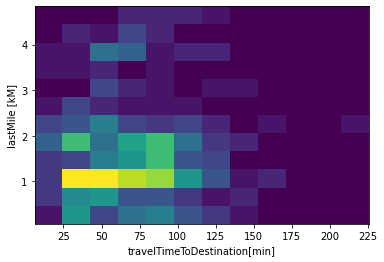

In [27]:
from matplotlib import pyplot as plt

counts, x_axes, y_axes, m = plt.hist2d(x=trip_oa_df["feat_tripTime"].dropna(), y=trip_oa_df["feat_lastMile"].dropna(), bins=int(np.ceil(trip_oa_df["feat_tripTime"].shape[0]/40)))
plt.ylabel("lastMile [kM]")
plt.xlabel("travelTimeToDestination[min]")

In [ ]:
counts, x_axes, y_axes, m = plt.hist2d(x=trip_oa_df["feat_tripTime"].dropna(), y=trip_oa_df["feat_oaUserRating"].dropna(), bins=int(np.ceil(trip_oa_df["feat_tripTime"].shape[0]/40)))
plt.ylabel("oaUserRating")
plt.xlabel("travelTimeToDestination[min]")

In [ ]:
counts, axes = np.histogram(trip_oa_df["feat_tripTime"].dropna(), bins=int(np.ceil(trip_oa_df["feat_tripTime"].shape[0]/40)))
bin_size = 2
if(len(axes)>2):
    time_bins = axes[2::2]
    data0_bin = trip_oa_df.where(trip_oa_df.feat_tripTime < time_bins[0]).dropna(how="all")
    data0_bin = data0_bin.sort_values(by=["feat_oaUserRating", "feat_lastMile", "feat_nsegments_trip"],)
    dfs = [data0_bin]
    for i,time_bin in enumerate(time_bins[1:]):
        data_bin = trip_oa_df.where(trip_oa_df.feat_tripTime < time_bin).where(trip_oa_df.feat_tripTime > time_bins[i-1]).dropna(how="all")
        data_bin = data_bin.sort_values(by=["feat_lastMile", "feat_nsegments_trip"], ascending=True)
        dfs.append(data_bin)

    trip_oa_df= data0_bin.append(dfs)
else:
    trip_oa_df= trip_oa_df.sort_values(by=["feat_tripTime", "feat_lastMile", "feat_nsegments_trip"],)


In [ ]:
trip_oa_df

In [ ]:
trip_oa_df.columns

In [ ]:
trip_oa_df.p

,lineOptions,time,length,elevation,rating,labels,startingPoint,season,startingPointDescr,directions,...,closeStations,nextStation,tripsToDestination,fastestTripToDestination,tripsToHome,fastestTripHome,feat_tripTime,feat_nsegments_trip,feat_lastMile,feat_oaUserRating
24,{'strokeColor': '#9e324a'},{'min': 225},11005.000000,"{'ascent': 523, 'descent': 523, 'minAltitude':...","{'condition': 4, 'difficulty': 2, 'technique':...",{'top': True},"{'lon': 8.855526, 'lat': 46.86818999999999}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Klausenpass, Bushaltestelle",Klausenpass - Firnband - Gemsfairenhüttli - Fi...,...,"[{'type': 'STATION', 'uicOrId': '8508368', 'na...","{'type': 'STATION', 'uicOrId': '8508368', 'nam...",[{'tripId': '0-x3wSQoCVjES8QzCtkhLScK2VCRBPTFA...,{'tripId': '0-x3wSQoCVjES8QzCtkhLScK2VCRBPTFAT...,[{'tripId': '4hXwSQoCVjESswrCtkhLScK2VCRBPTFAT...,{'tripId': '2BvwSQoCVjESmA3CtkhLScK2VCRBPTFATz...,42.0,3.0,1.36,-12.0
56,{'strokeColor': '#8b5831'},{'min': 150},20456.000000,"{'ascent': 792, 'descent': 792, 'minAltitude':...","{'condition': 3, 'difficulty': 2, 'technique':...",{'top': True},"{'lon': 9.093872, 'lat': 47.130829000000006}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Weesen, Bahnhof",Weesen - Ziegelbrücke - Schänis - Schwanten - ...,...,"[{'type': 'STATION', 'uicOrId': '8591315', 'na...","{'type': 'STATION', 'uicOrId': '8591300', 'nam...",[{'tripId': 'nAzwSQoCVjESmQbCtkhLScK2VCRBPTFAT...,{'tripId': 'nAzwSQoCVjESmQbCtkhLScK2VCRBPTFATz...,[{'tripId': 'qwvwSQoCVjESqQXCtkhLScK2VyRBPTFAT...,{'tripId': 'lwzwSQoCVjES2QbCtkhLScK2VyRBPTFATz...,31.0,3.0,0.94,-10.0
55,{'strokeColor': '#9e3293'},{'min': 311},45325.000000,"{'ascent': 1506, 'descent': 1506, 'minAltitude...","{'condition': 4, 'difficulty': 2, 'technique':...","{'top': True, 'publicTransportFriendly': True}","{'lon': 9.001928999999999, 'lat': 46.928209999...","{'jan': False, 'feb': False, 'mar': False, 'ap...",Linthal,Wir beginnen die Tour an der Linthal Braunwald...,...,"[{'type': 'STATION', 'uicOrId': '8502286', 'na...","{'type': 'STATION', 'uicOrId': '8502294', 'nam...",[{'tripId': '6g3wSQoCVjESkgbCtkhLScK2VCRBPTFAT...,{'tripId': '6g3wSQoCVjESkgbCtkhLScK2VCRBPTFATz...,[{'tripId': '8A_wSQoCVjES7gTCtkhLScK2VCRBPTFAT...,{'tripId': 'ww3wSQoCVjES6gTCtkhLScK2VCRBPTFATz...,21.0,2.0,2.36,-10.0
60,{'strokeColor': '#8b5831'},{'min': 210},30444.000000,"{'ascent': 719, 'descent': 727, 'minAltitude':...","{'condition': 5, 'difficulty': 3, 'technique':...",{'top': True},"{'lon': 8.16746, 'lat': 47.45145999999999}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Schinznach Bad, Bahnhof",Schinznach Bad - Wallbach - Linn - Linnerberg ...,...,"[{'type': 'STATION', 'uicOrId': '8591725', 'na...","{'type': 'STATION', 'uicOrId': '8594202', 'nam...",[{'tripId': '5Q_wSQoCVjESpQbCtkhLScK2VCRBPTFAT...,{'tripId': 'hQnwSQoCVjES_wTCtkhLScK2VCRBPTFATz...,[{'tripId': 'jgrwSQoCVjES3wTCtkhLScK2VCRBPTFAT...,{'tripId': 'jgrwSQoCVjES3wTCtkhLScK2VCRBPTFATz...,39.0,3.0,1.20,-8.0
49,{'strokeColor': '#8b5831'},{'min': 210},33122.000000,"{'ascent': 708, 'descent': 708, 'minAltitude':...","{'condition': 4, 'difficulty': 2, 'technique':...",{'top': True},"{'lon': 8.514481, 'lat': 47.174693}","{'jan': False, 'feb': False, 'mar': True, 'apr...","Zug, station",Zug - Baar - Neuägeri - Nollen - Walchwilerber...,...,"[{'type': 'STATION', 'uicOrId': '8573726', 'na...","{'type': 'STATION', 'uicOrId': '8576743', 'nam...",[{'tripId': '0gnwSQoCVjES5gTCtkhLScK2VCRBPTFAT...,{'tripId': '0QnwSQoCVjES5QTCtkhLScK2VCRBPTFATz...,[{'tripId': 'tgvwSQoCVjESpQXCtkhLScK2VCRBPTFAT...,{'tripId': 'tgvwSQoCVjESpQXCtkhLScK2VCRBPTFATz...,37.0,3.0,1.86,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,{'strokeColor': '#9e324a'},{'min': 540},32995.569217,"{'ascent': 623, 'descent': 661, 'minAltitude':...","{'condition': 6, 'difficulty': 3, 'technique':...",NaN,"{'lon': 8.902187, 'lat': 47.488572}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Aadorf, Ba

### Outdoor Activity Weather metric

In [ ]:
destination = trip_oa_df.iloc[0]
weather_request = getData.get_weather_request(time=starting_time+datetime.timedelta(minutes=destination['feat_tripTime']), location=[destination["startingPoint"]["lon"], destination["startingPoint"]["lat"]])
weather.get_weather(weather_request)


In [ ]:
weather.get_token()

## Get IMAGES

In [ ]:
trip_oa_df_path = "oa_df_withStations_withTrips.obj"
trip_oa_df = pd.read_pickle(trip_oa_df_path)


In [ ]:
from src.backend.utils import get_pictures
img_paths = get_pictures(trip_oa_df.iloc[3])
img_paths

In [ ]:
from ipywidgets import Image
from IPython import display

for img_path in img_paths:
    print(img_path)
    img = display.Image(img_path)
    display.display(img)